# Lecture 5 - Regression and Classification


## Learning goals

- Tell classification from regression by the target type.
- Load small chemistry-like datasets with SMILES and simple text features.
- Make train, validation, and test splits.
- Fit a simple regression model and a simple classification model.
- Read and compare common metrics in each case.
  [![Colab](https://img.shields.io/badge/Open-Colab-orange)](https://colab.research.google.com/drive/1UYUb5xw7lxDQrZYjJPixfILLrhFCYBlb?usp=sharing)

In [1]:
# Commented out IPython magic to ensure Python compatibility.
# 0. Setup
%pip install scikit-learn pandas matplotlib

try:
    from rdkit import Chem
    from rdkit.Chem import Draw, Descriptors, Crippen, rdMolDescriptors, AllChem
except Exception:
    try:
        %pip install rdkit
        from rdkit import Chem
        from rdkit.Chem import Draw, Descriptors, Crippen, rdMolDescriptors, AllChem
    except Exception as e:
        print("RDKit is not available in this environment. Drawing and descriptors will be skipped.")
        Chem = None


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names")
warnings.filterwarnings("ignore", message="X has feature names")

Note: you may need to restart the kernel to use updated packages.


## 1. What is supervised learning

```{admonition} Definition
- **Inputs** `X` are the observed features for each sample.
- **Target** `y` is the quantity you want to predict.
- **Regression** predicts a number. Example: a boiling point `300 F`.
- **Classification** predicts a category. Example: `high` solubility vs `low` solubility.
```

Rule of thumb:
- If **y** is real-valued, use regression.
- If **y** is a class label, use classification.


## 2. Data preview and descriptor engineering
We will read a small CSV from a public repository and compute a handful of molecular descriptors from SMILES. These lightweight features are enough to practice the full workflow.

```{admonition} Tip
Descriptors such as **molecular weight**, **logP**, **TPSA**, and **ring count** are simple to compute and often serve as a first baseline for structure-property relationships.
```

In [2]:
# Quick peek at the two datasets
df_oxidation_raw = pd.read_csv("https://raw.githubusercontent.com/zzhenglab/ai4chem/main/book/_data/C_H_oxidation_dataset.csv")
df_oxidation_raw

,Compound Name,CAS,SMILES,Solubility_mol_per_L,pKa,Toxicity,Melting Point,Reactivity,Oxidation Site
0,"3,4-dihydro-1H-isochromene",493-05-0,c1ccc2c(c1)CCOC2,0.103906,5.80,non_toxic,65.8,1,"8,10"
1,9H-fluorene,86-73-7,c1ccc2c(c1)Cc1ccccc1-2,0.010460,5.82,toxic,90.0,1,7
2,"1,2,3,4-tetrahydronaphthalene",119-64-2,c1ccc2c(c1)CCCC2,0.020589,5.74,toxic,69.4,1,"7,10"
3,ethylbenzene,100-41-4,CCc1ccccc1,0.048107,5.87,non_toxic,65.0,1,"1,2"
4,cyclohexene,110-83-8,C1=CCCCC1,0.060688,5.66,non_toxic,96.4,1,"3,6"
...,...,...,...,...,...,...,...,...,...
570,2-naphthalen-2-ylpropan-2-amine,90299-04-0,CC(C)(N)c1ccc2ccccc2c1,0.018990,10.04,toxic,121.5,-1,-1
571,"1-bromo-4-(methylamino)anthracene-9,10-dione",128-93-8,CNc1ccc(Br)c2c1C(=O)c1ccccc1C2=O,0.021590,7.81,toxic,154.0,-1,-1
572,1-[6-(dimethylamino)naphthalen-2-yl]prop-2-en-...,86636-92-2,C=CC(=O)c1ccc2cc(N(C)C)ccc2c1,0.017866,8.58,toxic,128.3,-1,-1
573,"1,2-dimethoxy-12-methyl-[1,3]benzodioxolo[5,6-...",34316-15-9,COc1ccc2c(c[n+](C)c3c4cc5c(cc4ccc23)OCO5)c1OC,0.016210,5.54,toxic,215.6,-1,-1


```{admonition} Think-pair-share
⏰
**Exercise 1.1**


Which column(s) can be target **y**?

Which are regression tasks and which are classification tasks?
```



Recall from last week that we can use SMILES to introduce additional descriptors:

In [3]:
def calc_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return pd.Series({
            "MolWt": None,
            "LogP": None,
            "TPSA": None,
            "NumRings": None
        })
    return pd.Series({
        "MolWt": Descriptors.MolWt(mol),                    # molecular weight
        "LogP": Crippen.MolLogP(mol),                       # octanol-water logP
        "TPSA": rdMolDescriptors.CalcTPSA(mol),             # topological polar surface area
        "NumRings": rdMolDescriptors.CalcNumRings(mol)      # number of rings
    })

# Apply the function to the SMILES column
desc_df = df_oxidation_raw["SMILES"].apply(calc_descriptors)

# Concatenate new descriptor columns to original DataFrame
df = pd.concat([df_oxidation_raw, desc_df], axis=1)
df

,Compound Name,CAS,SMILES,Solubility_mol_per_L,pKa,Toxicity,Melting Point,Reactivity,Oxidation Site,MolWt,LogP,TPSA,NumRings
0,"3,4-dihydro-1H-isochromene",493-05-0,c1ccc2c(c1)CCOC2,0.103906,5.80,non_toxic,65.8,1,"8,10",134.178,1.7593,9.23,2.0
1,9H-fluorene,86-73-7,c1ccc2c(c1)Cc1ccccc1-2,0.010460,5.82,toxic,90.0,1,7,166.223,3.2578,0.00,3.0
2,"1,2,3,4-tetrahydronaphthalene",119-64-2,c1ccc2c(c1)CCCC2,0.020589,5.74,toxic,69.4,1,"7,10",132.206,2.5654,0.00,2.0
3,ethylbenzene,100-41-4,CCc1ccccc1,0.048107,5.87,non_toxic,65.0,1,"1,2",106.168,2.2490,0.00,1.0
4,cyclohexene,110-83-8,C1=CCCCC1,0.060688,5.66,non_toxic,96.4,1,"3,6",82.146,2.1166,0.00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
570,2-naphthalen-2-ylpropan-2-amine,90299-04-0,CC(C)(N)c1ccc2ccccc2c1,0.018990,10.04,toxic,121.5,-1,-1,185.270,3.0336,26.02,2.0
571,"1-bromo-4-(methylamino)anthracene-9,10-dione",128-93-8,CNc1ccc(Br)c2c1C(=O)c1ccccc1C2=O,0.021590,7.81,toxic,154.0,-1,-1,316.154,3.2662,46.17,3.0
572,1-[6-(dimethylamino)naphthalen-2-yl]prop-2-en-...,86636-92-2,C=CC(=O)c1ccc2cc(N(C)C)ccc2c1,0.017866,8.58,toxic,128.3,-1,-1,225.291,3.2745,20.31,2.0
573,"1,2-dimethoxy-12-methyl-[1,3]benzodioxolo[5,6-...",34316-15-9,COc1ccc2c(c[n+](C)c3c4cc5c(cc4ccc23)OCO5)c1OC,0.016210,5.54,toxic,215.6,-1,-1,348.378,3.7166,40.80,5.0


---


## 3. Regression workflow on melting point

We start with a single property, the **Melting Point**, and use four descriptors as features.


Now let's first look at regression, we will focus one property prediction at a time. first create a new df"""

In [4]:
df_reg_mp =df[["Compound Name", "MolWt", "LogP", "TPSA", "NumRings","Melting Point"]]
df_reg_mp

,Compound Name,MolWt,LogP,TPSA,NumRings,Melting Point
0,"3,4-dihydro-1H-isochromene",134.178,1.7593,9.23,2.0,65.8
1,9H-fluorene,166.223,3.2578,0.00,3.0,90.0
2,"1,2,3,4-tetrahydronaphthalene",132.206,2.5654,0.00,2.0,69.4
3,ethylbenzene,106.168,2.2490,0.00,1.0,65.0
4,cyclohexene,82.146,2.1166,0.00,1.0,96.4
...,...,...,...,...,...,...
570,2-naphthalen-2-ylpropan-2-amine,185.270,3.0336,26.02,2.0,121.5
571,"1-bromo-4-(methylamino)anthracene-9,10-dione",316.154,3.2662,46.17,3.0,154.0
572,1-[6-(dimethylamino)naphthalen-2-yl]prop-2-en-...,225.291,3.2745,20.31,2.0,128.3
573,"1,2-dimethoxy-12-methyl-[1,3]benzodioxolo[5,6-...",348.378,3.7166,40.80,5.0,215.6


### 3.1 Train and test split

```{admonition} Why split?
We test on **held-out** data to estimate generalization. A common split is 80 percent train, 20 percent test with a fixed `random_state` for reproducibility.
```


### 3.2 Splitting the data and train

Before training, we need to separate the input features (`X`) from the target (`y`). Then we split into training and test sets to evaluate how well the model generalizes.

In [5]:
from sklearn.model_selection import train_test_split

# Define X (features) and y (target)
X = df_reg_mp[["MolWt", "LogP", "TPSA", "NumRings"]]
y = df_reg_mp["Melting Point"]

# Split into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape

X_train

y_train

68     152.1
231    169.4
63     247.3
436    160.0
60     127.8
       ...  
71     126.6
106    125.3
270    207.8
435    157.9
102     57.5
Name: Melting Point, Length: 460, dtype: float64

```{admonition} Visual check
Scatter the training and test points for one descriptor vs the target to see coverage. This is a quick check for weird splits or narrow ranges.
```


Since we have 575 rows in total, we splited it into 460 train + 115 test and these are shuffled.

It’s often useful to check how the training and test sets are distributed. Here we’ll do a scatter plot of one descriptor (say `MolWt`) against the target (`Melting Point`) and color by train/test.

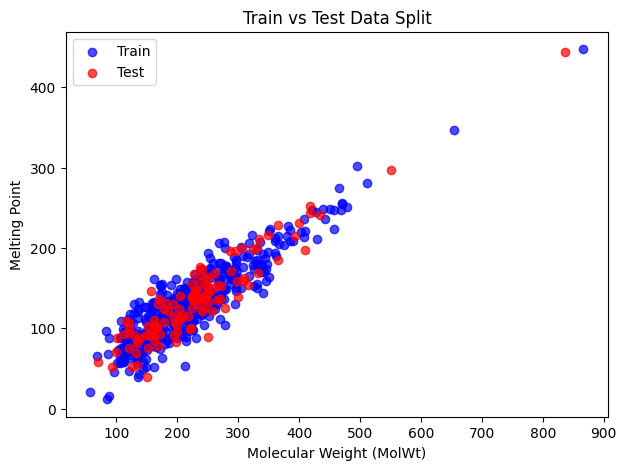

In [6]:
import matplotlib.pyplot as plt

# Plot training vs test data
plt.figure(figsize=(7,5))
plt.scatter(X_train["MolWt"], y_train, color="blue", label="Train", alpha=0.7)
plt.scatter(X_test["MolWt"], y_test, color="red", label="Test", alpha=0.7)
plt.xlabel("Molecular Weight (MolWt)")
plt.ylabel("Melting Point")
plt.title("Train vs Test Data Split")
plt.legend()
plt.show()

Blue points are the training set and red points are the test set. We can see that the split looks balanced and the test set covers a different range of values.

In [7]:
# Initialize model
reg = LinearRegression()

# Fit to training data
reg.fit(X_train, y_train)

# Predict on test set
y_pred = reg.predict(X_test)

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("MAE:", mae)
print("R2:", r2)

MSE: 374.56773278929023
MAE: 15.316390819320329
R2: 0.8741026174988968


Below are metrics, with formulas:

- **Mean Squared Error (MSE):**  
 $
  \text{MSE} = \frac{1}{n}\sum_{i=1}^{n} (y_i - \hat{y}_i)^2
    $
  
  Squared differences; penalizes large errors heavily.

- **Mean Absolute Error (MAE):**  
   $
  \text{MAE} = \frac{1}{n}\sum_{i=1}^{n} |y_i - \hat{y}_i|
   $   
  Easier to interpret; average magnitude of errors.

- **R² (Coefficient of Determination):**  
   $
  R^2 = 1 - \frac{\sum (y_i - \hat{y}_i)^2}{\sum (y_i - \bar{y})^2}
   $   
  Measures proportion of variance explained by the model.  
  -  $ R^2 = 1 $ : perfect prediction  
  -  $ R^2 = 0 $ : model is no better than mean  
  -  $ R^2 < 0 $ : worse than predicting the average



⏰
**Exercise 2.1**


Change the test_size=0.2 to 0.1 and random_state=42 to 7 to see any difference in resulting MSE, MAE and R2.

Now you can use `reg` to make predictions

In [8]:
# Single new data point with 2 features
X_new = np.array([[135, 2, 9.2, 2]]) # ["MolWt", "LogP", "TPSA", "NumRings"]]
y_new_pred = reg.predict(X_new)

print("Predicted value:", y_new_pred)

Xs_new = np.array([[135, 2, 9.2, 2],
                  [301, 0.5, 17.7, 2],
                  [65, 1.3, 20.0, 1]]) # ["MolWt", "LogP", "TPSA", "NumRings"]]
ys_new_pred = reg.predict(Xs_new)

print("Predicted value:", ys_new_pred)

Predicted value: [86.80836978]
Predicted value: [ 86.80836978 169.99905967  53.35729424]


```{admonition} Diagnostic plots
A residual plot should look centered around zero without obvious patterns. A parity plot compares predicted to true values and should line up near the 45 degree line.
```

After training, we compare the predicted outputs with the true labels from the test set. 

This allows us to verify how close the model’s predictions are to the actual values.

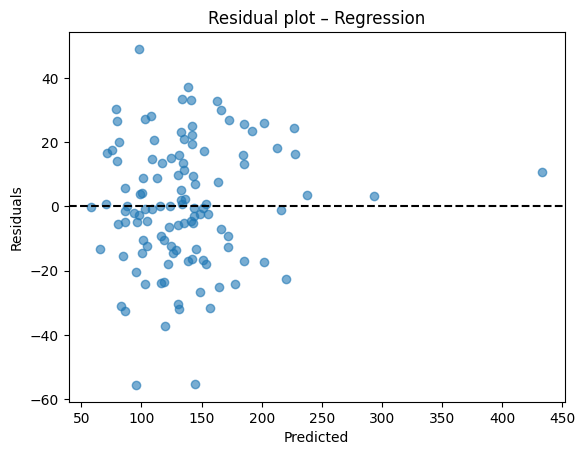

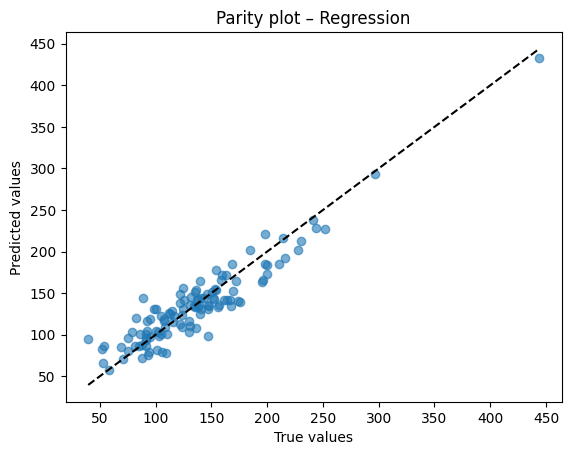

In [9]:
# Residual plot
resid = y_test - y_pred
plt.scatter(y_pred, resid, alpha=0.6)
plt.axhline(0, color="k", linestyle="--")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residual plot – Regression")
plt.show()

# Parity plot
plt.scatter(y_test, y_pred, alpha=0.6)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, "k--")
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("Parity plot – Regression")
plt.show()

### 3.3 How split choice affects accuracy

Besides, we can examine how different splitting strategies influence the accuracy.

Effect of split on accuracy


,test_size,MSE_mean,MSE_std,MAE_mean,MAE_std,R2_mean,R2_std,n_train_mean,n_test_mean
0,0.1,389.5968,75.9762,15.5954,1.7249,0.8338,0.0559,517.0,58.0
1,0.2,400.1363,47.3691,15.8006,1.0476,0.8433,0.0363,460.0,115.0
2,0.3,401.9008,42.3394,15.8713,0.8514,0.8412,0.0268,402.0,173.0


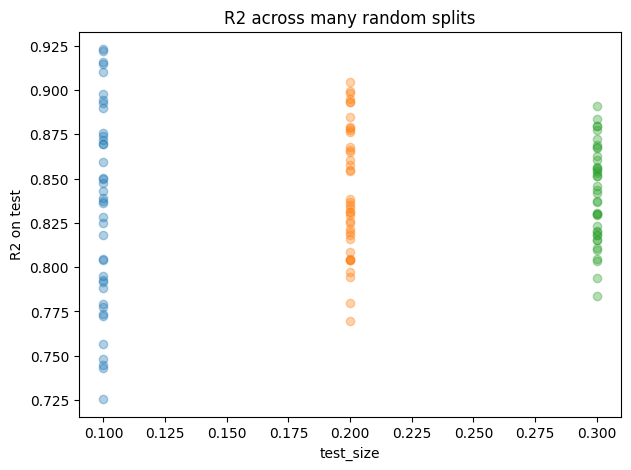

test_size=0.2, seed=15 -> MSE=415.498, MAE=16.380, R2=0.805
test_size=0.2, seed=42 -> MSE=374.568, MAE=15.316, R2=0.874
test_size=0.1, seed=42 -> MSE=324.998, MAE=13.861, R2=0.872
test_size=0.1, seed=7 -> MSE=361.085, MAE=15.025, R2=0.893


In [10]:
test_sizes = [0.10, 0.20, 0.30]
seeds = range(40)  # more seeds = smoother distributions

rows = []
for t in test_sizes:
    for s in seeds:
        X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=t, random_state=s)
        reg = LinearRegression().fit(X_tr, y_tr)
        y_hat = reg.predict(X_te)
        rows.append({
            "test_size": t,
            "seed": s,
            "MSE": mean_squared_error(y_te, y_hat),
            "MAE": mean_absolute_error(y_te, y_hat),
            "R2": r2_score(y_te, y_hat),
            "n_train": len(X_tr),
            "n_test": len(X_te),
        })

df_splits = pd.DataFrame(rows)

# Summary table
summary = (df_splits
           .groupby("test_size")
           .agg(MSE_mean=("MSE","mean"), MSE_std=("MSE","std"),
                MAE_mean=("MAE","mean"), MAE_std=("MAE","std"),
                R2_mean=("R2","mean"),   R2_std=("R2","std"),
                n_train_mean=("n_train","mean"), n_test_mean=("n_test","mean"))
           .reset_index())
print("Effect of split on accuracy")
display(summary.round(4))

# Simple R2 scatter by test_size to visualize spread
plt.figure(figsize=(7,5))
for t in test_sizes:
    vals = df_splits.loc[df_splits["test_size"]==t, "R2"].values
    plt.plot([t]*len(vals), vals, "o", alpha=0.35, label=f"test_size={t}")
plt.xlabel("test_size")
plt.ylabel("R2 on test")
plt.title("R2 across many random splits")
plt.show()

# One-shot comparison matching your exercise idea
for test_size, seed in [(0.2, 15), (0.2, 42), (0.1, 42),(0.1, 7)]:
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=test_size, random_state=seed)
    reg = LinearRegression().fit(X_tr, y_tr)
    y_hat = reg.predict(X_te)
    print(f"test_size={test_size}, seed={seed} -> "
          f"MSE={mean_squared_error(y_te,y_hat):.3f}, "
          f"MAE={mean_absolute_error(y_te,y_hat):.3f}, "
          f"R2={r2_score(y_te,y_hat):.3f}")

```{admonition} Reproducibility
`random_state` fixes the shuffle used by `train_test_split`. Same seed gives the same split so your metrics are stable from run to run.
```

### 3.4 Learning curves


A random `seed` is simply a number provided to a random number generator to ensure that it produces the same sequence of “random” results each time.

For example, functions such as `train_test_split` shuffle the dataset before dividing it into training and testing sets. If you do not specify a `random_state` (the seed), every run may produce a slightly different split. This variation can lead to different accuracy values across runs.

**Same seed → same split → same results**

**Different seed → different split → possibly different accuracy**

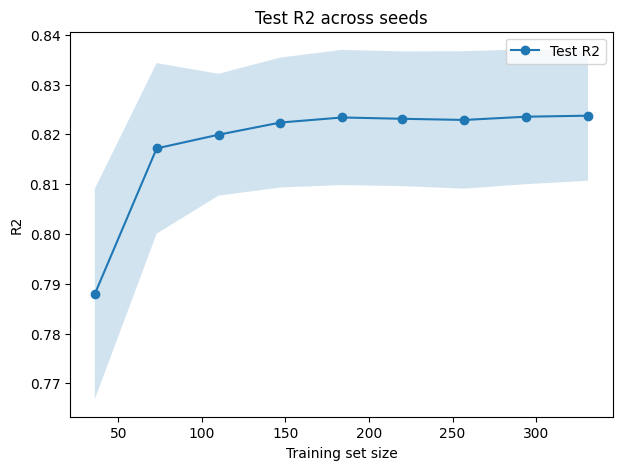

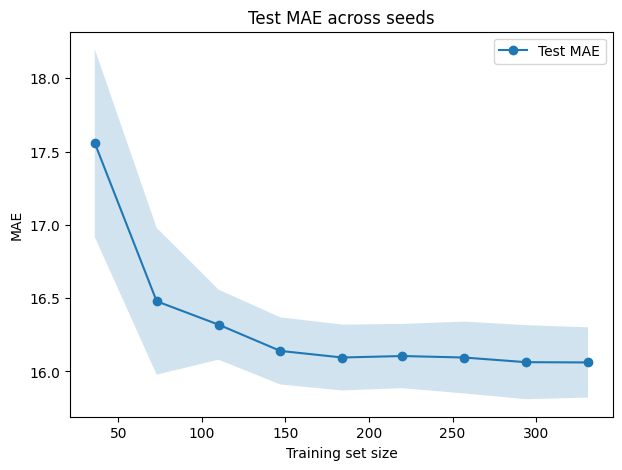

In [11]:
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt

seeds = [0, 1, 2, 3, 4]
train_sizes = np.linspace(0.1, 0.9, 9)

# Storage for test scores
test_scores_r2_all = []
test_scores_mae_all = []

for seed in seeds:
    # Fixed train-test split per seed
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

    # R²
    train_sizes_abs, train_scores_r2, test_scores_r2 = learning_curve(
        estimator=LinearRegression(), 
        X=X_train, y=y_train,
        train_sizes=train_sizes, 
        scoring="r2", 
        shuffle=False
    )
    test_scores_r2_all.append(test_scores_r2.mean(axis=1))

    # MAE
    _, train_scores_mae, test_scores_mae = learning_curve(
        estimator=LinearRegression(), 
        X=X_train, y=y_train,
        train_sizes=train_sizes, 
        scoring="neg_mean_absolute_error", 
        shuffle=False
    )
    test_scores_mae_all.append(-test_scores_mae.mean(axis=1))

# Convert to arrays
test_scores_r2_all = np.array(test_scores_r2_all)
test_scores_mae_all = np.array(test_scores_mae_all)

# Mean and std across seeds
test_mean_r2 = test_scores_r2_all.mean(axis=0)
test_std_r2  = test_scores_r2_all.std(axis=0)
test_mean_mae = test_scores_mae_all.mean(axis=0)
test_std_mae  = test_scores_mae_all.std(axis=0)

# Plot R²
plt.figure(figsize=(7,5))
plt.plot(train_sizes_abs, test_mean_r2, "o-", label="Test R2")
plt.fill_between(train_sizes_abs, test_mean_r2 - test_std_r2, test_mean_r2 + test_std_r2, alpha=0.2)
plt.xlabel("Training set size")
plt.ylabel("R2")
plt.title("Test R2 across seeds")
plt.legend()
plt.show()

# Plot MAE
plt.figure(figsize=(7,5))
plt.plot(train_sizes_abs, test_mean_mae, "o-", label="Test MAE")
plt.fill_between(train_sizes_abs, test_mean_mae - test_std_mae, test_mean_mae + test_std_mae, alpha=0.2)
plt.xlabel("Training set size")
plt.ylabel("MAE")
plt.title("Test MAE across seeds")
plt.legend()
plt.show()


### 3.5 Regularization: Lasso and Ridge

Now, instead of using **Linear Regression**, we can also experiment with other models such as **Lasso Regression**. These alternatives add regularization, which helps prevent overfitting by penalizing overly complex models.  

So, how does `.fit(X, y)` work?  

When you call `model.fit(X, y)`, the following steps occur:  

1. **Model receives the data**  
   - **X**: the feature matrix (input variables).  
   - **y**: the target values (labels you want the model to predict).  

2. **Optimization process**  
   - **Linear Regression**: finds the line, plane, or hyperplane that minimizes the **Mean Squared Error (MSE)** between predictions and true values.  
   - **Ridge Regression**: minimizes MSE but adds an **L2 penalty** (squares of the coefficients) to shrink coefficients and control variance.  
   - **Lasso Regression**: minimizes MSE but adds an **L1 penalty** (absolute values of the coefficients), which can drive some coefficients exactly to zero, effectively performing **feature selection**.  

This optimization is usually solved through iterative algorithms that adjust coefficients until the cost function reaches its minimum.  


Now, instead of linear regression, we can also try other, such as lasso regression.


```{admonition} Losses
- **Linear**  
  $
  \hat{y} = w^\top x + b,\quad
  \mathrm{Loss} = \frac{1}{n}\sum (y_i - \hat{y}_i)^2
  $

- **Lasso**  
  $
  \mathrm{Loss} = \frac{1}{n}\sum (y_i - \hat{y}_i)^2 + \alpha \sum_j \lvert w_j \rvert
  $

- **Ridge**  
  $
  \mathrm{Loss} = \frac{1}{n}\sum (y_i - \hat{y}_i)^2 + \alpha \sum_j w_j^2
  $
```

In [12]:
# Initialize model (you can adjust alpha to control regularization strength)
reg_lasso = Lasso(alpha=0.1)

# Fit to training data
reg_lasso .fit(X_train, y_train)

# Predict on test set
y_pred = reg_lasso .predict(X_test)

# Evaluate performance
mse_lasso = mean_squared_error(y_test, y_pred)
mae_lasso = mean_absolute_error(y_test, y_pred)
r2_lasso = r2_score(y_test, y_pred)

print("For Lasso regression:")
print("MSE:", mse_lasso)
print("MAE:", mae_lasso)
print("R2:", r2_lasso)
print("--------------")
print("For Linear regression:")
print("MSE:", mse)
print("MAE:", mae)
print("R2:", r2)

For Lasso regression:
MSE: 329.0917965850995
MAE: 14.768600346156408
R2: 0.8788521790542615
--------------
For Linear regression:
MSE: 374.56773278929023
MAE: 15.316390819320329
R2: 0.8741026174988968


You can see here that, in fact, **Linear Regression performs slightly better than Lasso Regression**, which shows that a more complex model is not always the better choice.  

The prediction rule for Linear Regression is:  

$$
\hat{y} = w_1x_1 + w_2x_2 + \dots + w_px_p + b
$$

We will also look at **Ridge Regression**, which adds an L2 penalty to the loss function:  

$$
\text{Loss} = \frac{1}{n}\sum_{i=1}^n (y_i - \hat{y}_i)^2 + \alpha \sum_{j=1}^p w_j^2
$$

In [13]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Initialize model (tune alpha for regularization strength)
reg_ridge = Ridge(alpha=1.0)

# Fit to training data
reg_ridge.fit(X_train, y_train)

# Predict on test set
y_pred_ridge = reg_ridge.predict(X_test)

# Evaluate performance
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print("For Ridge regression:")
print("MSE:", mse_ridge)
print("MAE:", mae_ridge)
print("R2:", r2_ridge)
print("--------------")
print("For Linear regression:")
print("MSE:", mse)
print("MAE:", mae)
print("R2:", r2)

For Ridge regression:
MSE: 329.17713339699617
MAE: 14.763612712404363
R2: 0.87882076420614
--------------
For Linear regression:
MSE: 374.56773278929023
MAE: 15.316390819320329
R2: 0.8741026174988968


We can see here that the models have very similar performance.  

Now, what about predicting actual values such as **solubility**?  

---


## 4. Another regression target: solubility in log space

Let’s try doing the same process by defining the following molecular descriptors as our input features (**X**):  

- `molwt` (molecular weight)  
- `logp` (partition coefficient)  
- `tpsa` (topological polar surface area)  
- `numrings` (number of rings)  

Our target (**y**) will be the **solubility** column.

In [14]:
# 1. Select features (X) and target (y)
X = df[["MolWt", "LogP", "TPSA", "NumRings"]]
y = df["Solubility_mol_per_L"]

# 2. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Linear Regression
reg_linear = LinearRegression()
reg_linear.fit(X_train, y_train)
y_pred_linear = reg_linear.predict(X_test)

mse_linear = mean_squared_error(y_test, y_pred_linear)
mae_linear = mean_absolute_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

print("For Linear regression:")
print("MSE:", mse_linear)
print("MAE:", mae_linear)
print("R2:", r2_linear)
print("--------------")

# 4. Ridge Regression
reg_ridge = Ridge(alpha=1.0)
reg_ridge.fit(X_train, y_train)
y_pred_ridge = reg_ridge.predict(X_test)

mse_ridge = mean_squared_error(y_test, y_pred_ridge)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print("For Ridge regression:")
print("MSE:", mse_ridge)
print("MAE:", mae_ridge)
print("R2:", r2_ridge)
print("--------------")

# 5. Lasso Regression
reg_lasso = Lasso(alpha=0.01, max_iter=10000)  # alpha can be tuned
reg_lasso.fit(X_train, y_train)
y_pred_lasso = reg_lasso.predict(X_test)

mse_lasso = mean_squared_error(y_test, y_pred_lasso)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print("For Lasso regression:")
print("MSE:", mse_lasso)
print("MAE:", mae_lasso)
print("R2:", r2_lasso)
print("--------------")

For Linear regression:
MSE: 5445.949091807627
MAE: 48.59778162610544
R2: -22609.20768075587
--------------
For Ridge regression:
MSE: 5421.635487770039
MAE: 48.47750955001047
R2: -22508.263726361492
--------------
For Lasso regression:
MSE: 5445.226685332671
MAE: 48.59194974571603
R2: -22606.208431193794
--------------


The results here are very poor, with a strongly negative $R^2$ value.  




```{admonition} Stabilize with logs
Targets like solubility are commonly modeled as `logS`. Taking logs reduces the influence of extreme values and can improve fit quality.
```
So instead of fitting the solubility values directly, we transform them using:  

$$
y' = \log_{10}(\text{Solubility})
$$

This way, we predict $y'$ (log-scaled solubility) rather than the raw solubility.

In [15]:
# 1. Select features (X) and target (y)
X = df[["MolWt", "LogP", "TPSA", "NumRings"]]

######################### ##################### #####################
y = np.log10(df["Solubility_mol_per_L"] + 1e-6)  # avoid log(0)
######################### all other code stay the same #####################


# 2. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Linear Regression
reg_linear = LinearRegression()
reg_linear.fit(X_train, y_train)
y_pred_linear = reg_linear.predict(X_test)

mse_linear = mean_squared_error(y_test, y_pred_linear)
mae_linear = mean_absolute_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

print("For Linear regression:")
print("MSE:", mse_linear)
print("MAE:", mae_linear)
print("R2:", r2_linear)
print("--------------")

# 4. Ridge Regression
reg_ridge = Ridge(alpha=1.0)
reg_ridge.fit(X_train, y_train)
y_pred_ridge = reg_ridge.predict(X_test)

mse_ridge = mean_squared_error(y_test, y_pred_ridge)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print("For Ridge regression:")
print("MSE:", mse_ridge)
print("MAE:", mae_ridge)
print("R2:", r2_ridge)
print("--------------")

# 5. Lasso Regression
reg_lasso = Lasso(alpha=0.01, max_iter=10000)  # alpha can be tuned
reg_lasso.fit(X_train, y_train)
y_pred_lasso = reg_lasso.predict(X_test)

mse_lasso = mean_squared_error(y_test, y_pred_lasso)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print("For Lasso regression:")
print("MSE:", mse_lasso)
print("MAE:", mae_lasso)
print("R2:", r2_lasso)
print("--------------")

For Linear regression:
MSE: 0.01839145854075597
MAE: 0.11527716464692464
R2: 0.9596775333018727
--------------
For Ridge regression:
MSE: 0.018411193365126914
MAE: 0.11530263164973845
R2: 0.9596342655644756
--------------
For Lasso regression:
MSE: 0.018796068172089866
MAE: 0.11631355339741077
R2: 0.95879044442042
--------------


Now, much better, right? Now, what happen if instead transforming `y`, you actually transforming `x`? Try it by yourself after class.

---


## 5. Binary classification: toxicity

We turn to a yes or no outcome, using the same four descriptors. Logistic Regression outputs probabilities. A threshold converts those into class predictions.

We will build a binary classifier for **Toxicity** using the pre-built table:

In [16]:
df_clf_tox =df[["Compound Name", "MolWt", "LogP", "TPSA", "NumRings","Toxicity"]]
df_clf_tox

,Compound Name,MolWt,LogP,TPSA,NumRings,Toxicity
0,"3,4-dihydro-1H-isochromene",134.178,1.7593,9.23,2.0,non_toxic
1,9H-fluorene,166.223,3.2578,0.00,3.0,toxic
2,"1,2,3,4-tetrahydronaphthalene",132.206,2.5654,0.00,2.0,toxic
3,ethylbenzene,106.168,2.2490,0.00,1.0,non_toxic
4,cyclohexene,82.146,2.1166,0.00,1.0,non_toxic
...,...,...,...,...,...,...
570,2-naphthalen-2-ylpropan-2-amine,185.270,3.0336,26.02,2.0,toxic
571,"1-bromo-4-(methylamino)anthracene-9,10-dione",316.154,3.2662,46.17,3.0,toxic
572,1-[6-(dimethylamino)naphthalen-2-yl]prop-2-en-...,225.291,3.2745,20.31,2.0,toxic
573,"1,2-dimethoxy-12-methyl-[1,3]benzodioxolo[5,6-...",348.378,3.7166,40.80,5.0,toxic


```{admonition} Encoding
Map text labels to numbers so that the model can learn from them. Keep an eye on class balance.
```

We will perform the following steps:  

1. **Map labels to numeric values**  
   - `toxic` → 1  
   - `non_toxic` → 0  

2. **Select features for training**  
   - `MolWt` (Molecular Weight)  
   - `LogP` (Partition Coefficient)  
   - `TPSA` (Topological Polar Surface Area)  
   - `NumRings` (Number of Rings)

In [17]:
import numpy as np
import pandas as pd

# Label encode
label_map = {"toxic": 1, "non_toxic": 0}
y = df_clf_tox["Toxicity"].str.lower().map(label_map).astype(int)

# Feature matrix
X = df_clf_tox[["MolWt", "LogP", "TPSA", "NumRings"]].values

# Just to be sure there are no infinities
mask_finite = np.isfinite(X).all(axis=1)
X = X[mask_finite]
y = y[mask_finite]

X[:3], y[:10]

(array([[134.178 ,   1.7593,   9.23  ,   2.    ],
        [166.223 ,   3.2578,   0.    ,   3.    ],
        [132.206 ,   2.5654,   0.    ,   2.    ]]),
 0    0
 1    1
 2    1
 3    0
 4    0
 5    0
 6    0
 7    0
 8    1
 9    1
 Name: Toxicity, dtype: int32)

When splitting the data into training and test sets, we will use **stratification**.  


```{admonition} Why stratification
Stratification ensures that the proportion of labels (toxic vs non-toxic) remains approximately the same in both the training and test sets. This prevents issues where one split might have many more examples of one class than the other, which could bias model evaluation.  
```

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)
print("Train class balance:", y_train.mean().round(3), " 1 = toxic")
print("Test class balance:", y_test.mean().round(3))

Train shape: (460, 4)  Test shape: (115, 4)
Train class balance: 0.824  1 = toxic
Test class balance: 0.826


The name **LogisticRegression** can be a bit misleading. Even though it contains the word *regression*, it is **not** used for predicting continuous values.  

```{admonition} Difference
Logistic Regression → for classification (e.g., spam vs. not spam, toxic vs. not toxic). It outputs probabilities between `0` and `1`. A threshold (commonly `0.5`) is then applied to assign class labels.  

Linear Regression → for regression (predicting continuous numbers, like prices, scores, or temperatures).
```


Remember:
Logistic Regression is for classification. It models probability of class 1. Linear Regression is for continuous targets.

In [19]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Predictions and probabilities
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]  # probability of toxic = 1
y_pred,  y_proba

(array([1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 0, 1]),
 array([0.97365453, 0.99999445, 0.07948438, 0.99928248, 0.99808894,
        0.99988604, 0.38728779, 0.28315917, 0.98259346, 0.91108836,
        1.        , 0.46860683, 0.98970239, 0.99999986, 1.        ,
        0.99999072, 0.19729071, 0.60959888, 0.99975044, 0.99999457,
        0.99998644, 0.99999999, 0.99971599, 1.        , 0.99875044,
        0.99895988, 0.99643145, 0.99999997, 0.99982696, 0.54798505,
        0.25983915, 0.99996566, 0.99016677, 0.99951381, 0.99997991,
        0.99457012, 0.68031579, 0.07968588, 0.99462309, 0.99898626,
        0.99837834, 0.19580473, 0.99981471, 0.99845567, 0.998

```{admonition} Metrics for classification
**Accuracy**: fraction of correct predictions.  

$$
\text{Accuracy} = \frac{TP + TN}{TP + FP + TN + FN}
$$

---

**Precision**: among predicted toxic, how many are truly toxic.  

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

---

**Recall**: among truly toxic, how many we caught.  

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

---

**F1**: harmonic mean of precision and recall.  

$$
\text{F1} = \frac{2 \cdot \text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

---

**AUC**: area under the ROC curve. Measures ranking of positives vs negatives over all thresholds.  
```

Now we can exame metrics:

In [20]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve
)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1:        {f1:.3f}")
print(f"AUC:       {auc:.3f}")

Accuracy:  0.957
Precision: 0.979
Recall:    0.968
F1:        0.974
AUC:       0.992


```{admonition} Confusion matrix and ROC
Inspect the mix of true vs predicted labels and visualize how sensitivity and specificity trade off across thresholds.
```

By default, most classifiers (such as Logistic Regression) use a threshold of **0.5**:  
- If predicted probability ≥ 0.5 → class = 1 (toxic)  
- If predicted probability < 0.5 → class = 0 (non-toxic)  

However, we can **change the threshold** depending on the problem:  
- Lowering the threshold (e.g., 0.3) increases sensitivity (recall), catching more positives but with more false positives.  
- Raising the threshold (e.g., 0.7) increases precision, reducing false positives but possibly missing some true positives.  

This trade-off is important in real-world settings. For example:  
- In medical screening, we may prefer higher recall (catch all possible cases).  
- In spam filtering, we may prefer higher precision (avoid marking valid emails as spam).

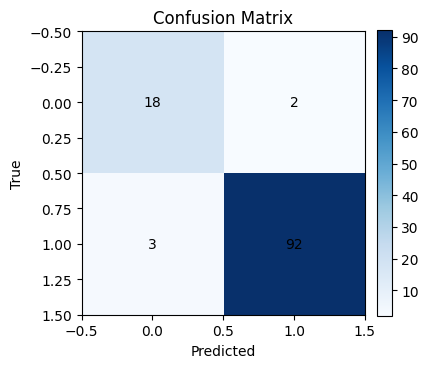

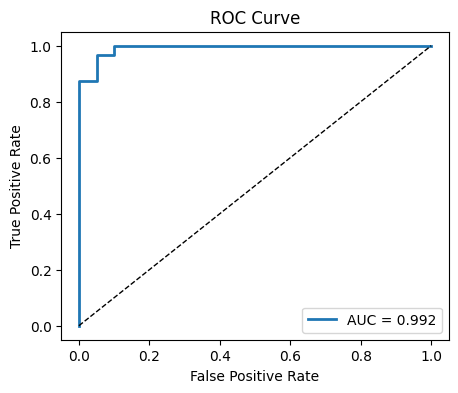

threshold: 0.350
Accuracy: 0.965
Precision: 0.960
Recall: 1.000
F1: 0.979
AUC: 0.992


In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,4))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="black")
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

# ROC curve
fpr, tpr, thr = roc_curve(y_test, y_proba)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, lw=2, label=f"AUC = {auc:.3f}")
plt.plot([0,1],[0,1], "k--", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

threshold = 0.35  # try 0.3, 0.5, 0.7
proba = clf.predict_proba(X_test)[:, 1]
pred = (proba >= threshold).astype(int)

print(f"threshold: {threshold:.3f}")
print(f"Accuracy: {accuracy_score(y_test, pred):.3f}")
print(f"Precision: {precision_score(y_test, pred):.3f}")
print(f"Recall: {recall_score(y_test, pred):.3f}")
print(f"F1: {f1_score(y_test, pred):.3f}")
print(f"AUC: {roc_auc_score(y_test, proba):.3f}")

Depending on how you set the classification threshold, the evaluation metrics will change.  

- If you use a **threshold = 0.5**, you will obtain exactly the same results as before (the default behavior).  
- Adjusting the threshold upward or downward will shift the balance between **precision** and **recall**, leading to different values for accuracy, F1 score, and other metrics.

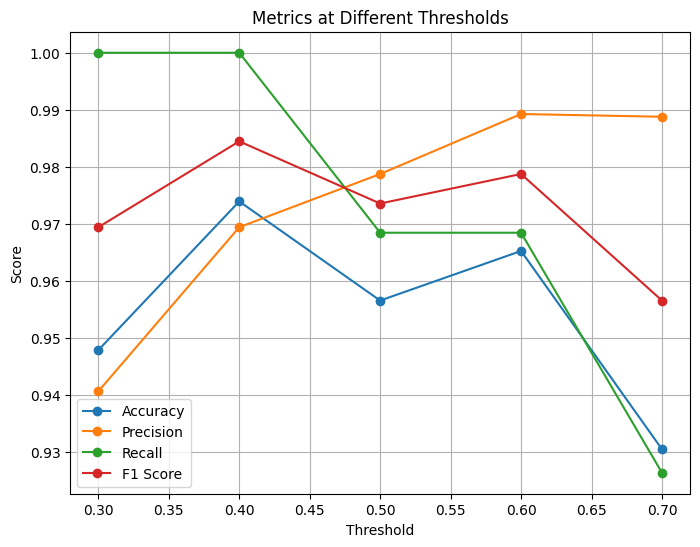

In [22]:
# Probabilities from your classifier
proba = clf.predict_proba(X_test)[:, 1]

# Threshold values
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]

# Store results
accuracy, precision, recall, f1 = [], [], [], []

for t in thresholds:
    pred = (proba >= t).astype(int)
    accuracy.append(accuracy_score(y_test, pred))
    precision.append(precision_score(y_test, pred))
    recall.append(recall_score(y_test, pred))
    f1.append(f1_score(y_test, pred))

# Plot metrics vs thresholds
plt.figure(figsize=(8, 6))
plt.plot(thresholds, accuracy, marker='o', label='Accuracy')
plt.plot(thresholds, precision, marker='o', label='Precision')
plt.plot(thresholds, recall, marker='o', label='Recall')
plt.plot(thresholds, f1, marker='o', label='F1 Score')

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Metrics at Different Thresholds")
plt.legend()
plt.grid(True)
plt.show()

---

## 6. From regression to classes: melting point bins



Now, let's think about this:
**Can regression question be turning into classificiation?**
> Turning `Melting Point` Regression into a 3-Class Classification Task

So far we treated melting point (MP) as a continuous variable and built regression models. Another approach is to discretize MP into categories and reframe the task as classification. This can be useful if we only need a decision (e.g., low vs. medium vs. high melting point) rather than an exact temperature.

We split melting points into three bins:  
> **Class 0 (Low):** MP ≤ 100 °C  
> **Class 1 (Medium):** 100 < MP ≤ 200 °C  
> **Class 2 (High):** MP > 200 °C  


This creates a categorical target suitable for classification models.

In [23]:
# Features: same as before
X = df_reg_mp[["MolWt", "LogP", "TPSA", "NumRings"]].values

# Define categorical target
mp = df_reg_mp["Melting Point"].values
y3 = pd.cut(
    mp,
    bins=[-np.inf, 100, 200, np.inf],
    labels=[0, 1, 2],
    right=True,
    include_lowest=True
).astype(int)
y3

# Train/test split with stratification (preserves class proportions)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y3, test_size=0.2, random_state=42
)
X_train,  y_train

(array([[226.703  ,   3.687  ,  26.3    ,   1.     ],
        [282.295  ,   2.5255 ,  52.6    ,   3.     ],
        [468.722  ,   7.5302 ,  43.37   ,   5.     ],
        ...,
        [277.106  ,   3.7688 ,  34.14   ,   3.     ],
        [215.061  ,   1.32648,  42.25   ,   2.     ],
        [134.222  ,   2.8114 ,   0.     ,   1.     ]]),
 array([1, 1, 2, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 2, 1, 1,
        0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
        1, 1, 0, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 2, 0, 1, 0, 1,
        1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 0, 2, 2, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2,
        0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 2, 0, 1, 2, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 2, 2, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1

```{admonition} Multinomial logistic regression
The logistic model extends naturally to more than two classes. Scikit-learn handles this under the hood.
```

Now we can train a **Logistic Regression** model on the melting point classification task.  

Logistic Regression is not limited to binary problems — it can be extended to handle **multiple classes**.  
- In the **multinomial** setting, the model learns separate decision boundaries for each class.  
- Each class receives its own probability, and the model assigns the label with the highest probability.  

This allows us to predict whether a compound falls into **low**, **medium**, or **high** melting point categories.

In [24]:
clf3 = LogisticRegression(max_iter=1000)
clf3.fit(X_train, y_train)

# Predictions
y_pred = clf3.predict(X_test)
y_proba = clf3.predict_proba(X_test)  # class probabilities

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average="macro")
rec = recall_score(y_test, y_pred, average="macro")
f1 = f1_score(y_test, y_pred, average="macro")



print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1:        {f1:.3f}")

Accuracy:  0.826
Precision: 0.795
Recall:    0.797
F1:        0.794


```{admonition} Averaging choices
For multiple classes there are different ways to average metrics across classes. **Macro** gives each class equal weight, **micro** aggregates counts, and **weighted** weights by class frequency.
```

Note: When moving from **binary classification** to **multi-class classification**, metrics like precision, recall, and F1 score cannot be defined in just one way.  
You need to decide **how to average** them across multiple classes. This is where strategies such as **macro**, **micro**, and **weighted** averaging come into play.  

### Macro Averaging  
- Compute the metric (precision, recall, or F1) **for each class separately**.  
- Take the **simple, unweighted average** across all classes.  
- Every class contributes equally, regardless of how many samples it has.  

**Example:**  
Suppose we have 3 classes:  
- Class 0: 500 samples  
- Class 1: 100 samples  
- Class 2: 50 samples  

If the model performs very well on **Class 0** (the large class) but very poorly on **Class 2** (the small class), **macro averaging** will penalize the model.  
This is because each class’s F1 score contributes equally to the final average, even though the class sizes are different.

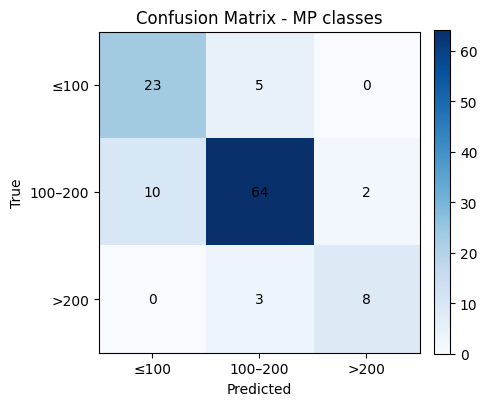

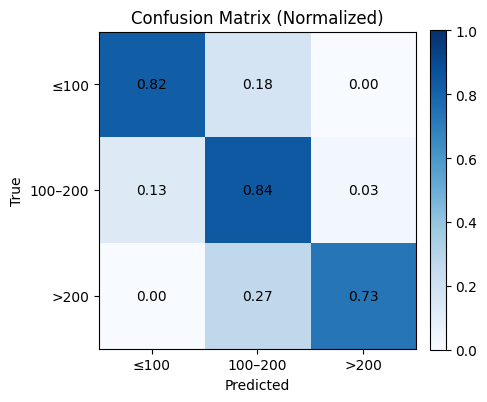

In [25]:
# Confusion matrix (counts)
labels = [0, 1, 2]  # 0: ≤100, 1: 100–200, 2: >200
cm = confusion_matrix(y_test, y_pred, labels=labels)

plt.figure(figsize=(4.8, 4.2))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix - MP classes")
plt.xlabel("Predicted")
plt.ylabel("True")

# Tick labels for bins
xticks = ["≤100", "100–200", ">200"]
yticks = ["≤100", "100–200", ">200"]
plt.xticks(np.arange(len(labels)), xticks, rotation=0)
plt.yticks(np.arange(len(labels)), yticks)

# Annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

# Optional: normalized confusion matrix (row-wise)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(4.8, 4.2))
plt.imshow(cm_norm, cmap="Blues", vmin=0, vmax=1)
plt.title("Confusion Matrix (Normalized)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(np.arange(len(labels)), xticks, rotation=0)
plt.yticks(np.arange(len(labels)), yticks)

for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        plt.text(j, i, f"{cm_norm[i, j]:.2f}", ha="center", va="center")

plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

---


## 8. Quick reference

```{admonition} Model recipes
- **LinearRegression**: `fit(X_train, y_train)` then `predict(X_test)`
- **Ridge(alpha=1.0)**: same API as LinearRegression
- **Lasso(alpha=...)**: same API, can shrink some coefficients to zero
- **LogisticRegression(max_iter=...)**: `predict` for labels, `predict_proba` for probabilities
```

```{admonition} Metrics at a glance
- Regression: **MSE**, **MAE**, **R²**
- Classification: **Accuracy**, **Precision**, **Recall**, **F1**, **AUC**
- Visuals: **residual plot**, **parity plot**, **confusion matrix**, **ROC**
```

```{admonition} Splits and seeds
- `train_test_split(X, y, test_size=0.2, random_state=42)`
- Use `stratify=y` for classification to maintain label balance
```

---

## 9. Glossary

```{glossary}
supervised learning
  A setup with features `X` and a labeled target `y` for each example.

regression
  Predicting a continuous number, such as a melting point.

classification
  Predicting a category, such as toxic vs non_toxic.

descriptor
  A numeric feature computed from a molecule. Examples: molecular weight, logP, TPSA, ring count.

train test split
  Partition the data into a part to fit the model and a separate part to estimate performance.

regularization
  Penalty added to the loss to discourage large weights. Lasso uses L1, Ridge uses L2.

residual
  The difference `y_true - y_pred` for a sample.

ROC AUC
  Area under the ROC curve, a threshold independent ranking score for binary classification.

macro averaging
  Average the metric per class, then take the unweighted mean across classes.

parity plot
  Scatter of predicted vs true values. Ideal points lie on the diagonal.
```


---

## 10. In-class activity


### 10.1 Linear Regression with two features

Use only `MolWt` and `TPSA` to predict **Melting Point** with Linear Regression. Use a 90/10 split and report **MSE**, **MAE**, and **R²**.

```python
X = df_reg_mp[["MolWt", "TPSA"]]
y = df_reg_mp["Melting Point"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=..., random_state=...
)

... #TO DO

print(f"MSE: {mean_squared_error(y_test, y_pred):.3f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.3f}")
print(f"R2:  {r2_score(y_test, y_pred):.3f}")
```

### 10.2 Ridge across splits

Train a Ridge model (`alpha=1.0`) for **Melting Point** using `MolWt, LogP, TPSA, NumRings`. Compare test **R²** for train sizes 60, 70, 80, 90 percent with `random_state=42`. Plot **R²** vs train percent.

```python
X = ... #TO DO
y = ... #TO DO

splits = [...]  # corresponds to 60/40, 70/30, 80/20, 90/10
r2_scores = [] # empty, no need to modify

for t in splits:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=t, random_state=... ... #TO DO
    )
    model = Ridge(alpha=1.0).fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2_scores.append(r2_score(y_test, y_pred))

# Plot results
plt.figure(figsize=(6,4))
plt.plot([60,70,80,90], r2_scores, "o-", lw=2)
plt.xlabel("Train %")
plt.ylabel("R² (test)")
plt.title("Effect of train/test split on Ridge Regression accuracy")
plt.show()
```

### 10.3 pKa regression two ways

Build Ridge regression for **pKa** using the same four descriptors. Report **R²** and **MSE** for each.

```python
... #TO DO
```

### 10.4 pKa to classification

Turn **pKa** into a binary label and train Logistic Regression with the same descriptors. Report Accuracy, Precision, Recall, F1, and AUC, and draw the ROC. You may pick either rule.

- Option A: acidic if pKa ≤ 7  
- Option B: median split on pKa

```python
... #TO DO
```

### 10.5 Threshold tuning on toxicity

Using the toxicity classifier from Section 5, scan thresholds `0.2` to `0.8` in steps of `0.05`. Find the smallest threshold with **recall ≥ 0.80** and report the corresponding **precision** and **F1**. Plot the metric curves vs threshold.
If needed, you can use ChatGPT to work on this question.

```python
... #TO DO
```
---